## Data Misalignment Impact Analysis - Money Customer Model
---

* Num miscategorized user groups.
    * people mistakenly provided a higher/lower risk group due to misalignment in data.
* Performance by switing from current money customer model to the refit


A lot of the preprocessing is contained in `900-before-production` and `901-analysis-on-data-alignment-impact`.

In [1]:
import sys, os, json
sys.path.append('../..')
import pandas as pd
import pickle as pkl
import lightgbm as lgb
from tqdm import tqdm
import numpy as np
import seaborn as sns
import src.monitoring.monitoring as mntr
from smart_open import open
import src.monitoring.utils as mu

import matplotlib.pyplot as plt
plt.style.use("seaborn")

%load_ext autoreload
%autoreload 2

In [2]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

def get_risk_groups_refitted(serie):
    return pd.cut(serie.round(), [300, 520, 550, 570, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

### Load Previous Data
---

In [3]:
s3_dir = "s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210931-refitted-model-to-prod-v2/"
dev_df_ = pd.read_parquet(os.path.join(s3_dir, "dev-20210915-scored.parquet"))
prod_df_ = pd.read_parquet(os.path.join(s3_dir, "prod-20210915-scored.parquet"))
score_df = pd.read_parquet(os.path.join(s3_dir, "dev-prod-scored-combined.parquet"))
combined_df = pd.read_parquet(os.path.join(s3_dir, "dev-prod-scored-combined_all_cols.parquet"))
test_df = pd.read_csv(os.path.join(s3_dir, "custom-test.csv"), index_col=0)

In [4]:
score_df.shape, combined_df.shape

((1109925, 14), (1109925, 159))

In [5]:
dev_df_1229 = pd.read_feather("../../data/combined_all_features/combined_1641542867.feather")
dev_df_1229 = dev_df_1229[dev_df_1229.sample_date==pd.to_datetime("2021-09-15")]

In [6]:
cols = ["target", "business_account_number", "user_id", "sample_date"]
target_df = dev_df_1229[cols]
target_df.columns = ["target_1229", "business_account_number", "user_id", "sample_date"]
combined_df = pd.merge(combined_df, target_df, on="user_id", how="inner", suffixes=("", "_target_df_1229"))
score_df = pd.merge(score_df, target_df, on="user_id", how="inner", suffixes=("", "_target_df_1229"))

In [7]:
active_ids = dev_df_[
        (dev_df_.nr_past_transactions > 0) & (dev_df_.nr_transactions_30d > 0)
    ].user_id.unique()

score_df["is_active"] = score_df.user_id.isin(active_ids)
combined_df["is_active"] = combined_df.user_id.isin(active_ids)

score_df.is_active.value_counts()

False    948357
True     162368
Name: is_active, dtype: int64

In [8]:
combined_df.target_1229.value_counts(dropna=False)

False    1102373
True        8352
Name: target_1229, dtype: int64

In [9]:
score_df.target_1229.value_counts(dropna=False)

False    1102373
True        8352
Name: target_1229, dtype: int64

In [10]:
score_df.head()

,user_id,business_account_number_exp,score_prod_exp,score_prod_act,score_dev_exp,score_dev_act,incumbent_model_score_dev_exp,incumbent_model_score_dev_act,score_dev_data_prod_model,score_dev_data_dev_model,score_prod_data_prod_model,score_prod_data_dev_model,incumbent_model_dev_data,incumbent_model_prod_data,target_1229,business_account_number,sample_date,is_active
0,305,410000276182,613.927501,616.901309,613.927501,616.901309,574.411334,573.720213,613.927501,613.927501,616.901309,616.901309,574.411334,573.720213,False,410000276182,2021-09-15,False
1,361,410000345005,476.012318,483.753944,476.012318,483.753944,478.306634,496.458316,476.012318,476.012318,483.753944,483.753944,478.306634,496.458316,False,410000345005,2021-09-15,True
2,637,410000300440,471.937248,445.956154,471.937248,445.956154,450.108314,444.716727,471.937248,471.937248,445.956154,445.956154,450.108314,444.716727,False,410000300440,2021-09-15,True
3,457,410011645378,543.099431,550.634507,543.099431,550.634507,503.178169,500.620276,543.099431,543.099431,550.634507,550.634507,503.178169,500.620276,False,410011645378,2021-09-15,False
4,468,410000331898,559.857236,559.977979,559.857236,559.977979,550.282359,525.433384,559.857236,559.857236,559.977979,559.977979,550.282359,525.433384,False,410000331898,2021-09-15,False


### Score diff distributions
---

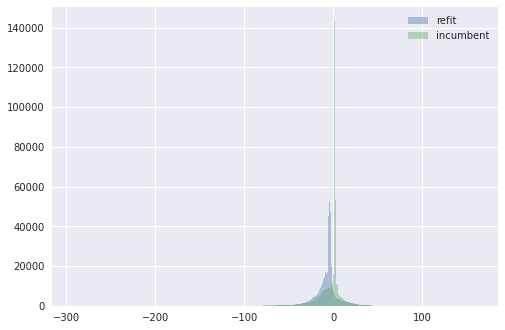

In [17]:
# dev vs. prod - incumbent and refit
nbins = 1000
(score_df.score_dev_data_dev_model - score_df.score_prod_data_prod_model).hist(bins=nbins, alpha=0.4, label="refit")
(score_df.incumbent_model_dev_data - score_df.incumbent_model_prod_data).hist(bins=nbins, alpha=0.4, label="incumbent")
plt.legend()
plt.show()

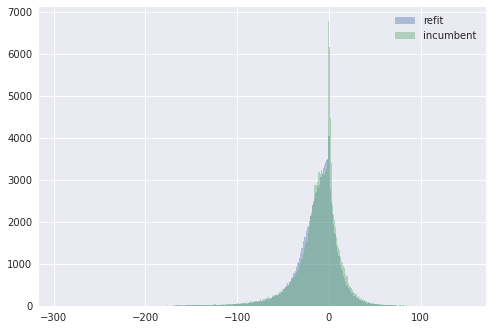

In [15]:
# dev vs. prod - incumbent and refit
score_df_active = score_df[score_df.is_active]

nbins = 500
(score_df_active.score_dev_data_dev_model - score_df_active.score_prod_data_prod_model).hist(bins=nbins, alpha=0.4, label="refit")
(score_df_active.incumbent_model_dev_data - score_df_active.incumbent_model_prod_data).hist(bins=nbins, alpha=0.4, label="incumbent")
plt.legend()
plt.show()

### Performance
---

```python
score_df["score_dev_data_prod_model"] = score_df["score_prod_exp"]
score_df["score_dev_data_dev_model"] = score_df["score_dev_exp"]
score_df["score_prod_data_prod_model"] = score_df["score_prod_act"]
score_df["score_prod_data_dev_model"] = score_df["score_dev_act"]
score_df["incumbent_model_dev_data"] = score_df["incumbent_model_score_dev_exp"]
score_df["incumbent_model_prod_data"] = score_df["incumbent_model_score_dev_act"]
```

In [28]:
score_df["target_1229"].value_counts(dropna=False)

False    1102373
True        8352
Name: target_1229, dtype: int64

all users:  1110725


,auc,ap
incumbent,63.21,6.63
refit,68.83,14.31


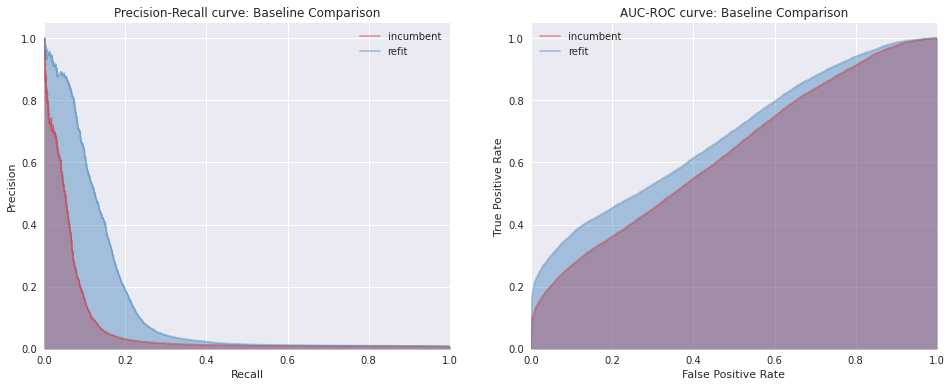

In [32]:
import src.monitoring.monitoring as mntr

df_tmp = score_df.copy()

df_tmp["incumbent"] = df_tmp["incumbent_model_prod_data"]
df_tmp["refit"] = df_tmp["score_prod_data_prod_model"]
pred_cols = ["incumbent", "refit"]
report = mntr.get_pred_reports(df_tmp, "target_1229", pred_cols)

print("all users: ", df_tmp.shape[0])
display(report[["auc", "ap"]])

mntr.save_valid_performance_plots(
        {"target_1229": df_tmp}, "target_1229", pred_cols, "/tmp/perf-plot.png", dropna=False
    )

all users:  162368


,auc,ap
incumbent,80.82,16.71
refit,84.92,26.24


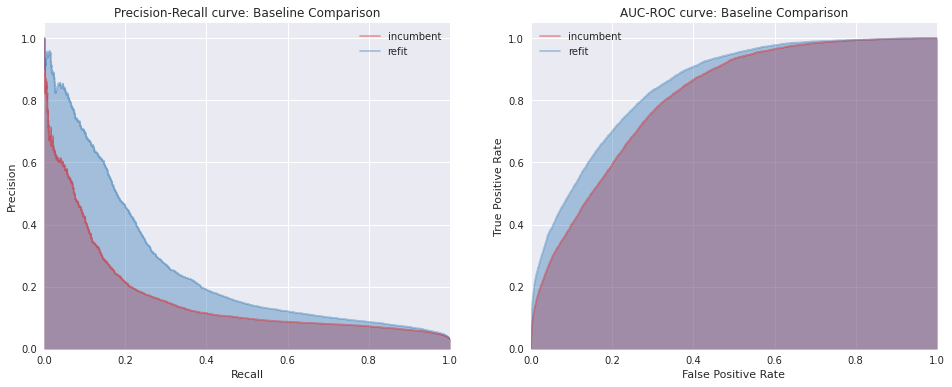

In [33]:
import src.monitoring.monitoring as mntr

df_tmp = score_df[score_df.is_active].copy()

df_tmp["incumbent"] = df_tmp["incumbent_model_prod_data"]
df_tmp["refit"] = df_tmp["score_prod_data_prod_model"]
pred_cols = ["incumbent", "refit"]
report = mntr.get_pred_reports(df_tmp, "target_1229", pred_cols)

print("all users: ", df_tmp.shape[0])
display(report[["auc", "ap"]])

mntr.save_valid_performance_plots(
        {"target_1229": df_tmp}, "target_1229", pred_cols, "/tmp/perf-plot.png", dropna=False
    )

### Risk Group Shifts - hold Model Constant and change data
---

#### Full Population

In [35]:
def get_lower_sum(m):
    return np.tril(m, k=-1).sum().sum()

def get_upper_sum(m):
    return np.triu(m, k=1).sum().sum()

1110725

'lower sum: '

100958

'upper sum: '

42679

Text(0.5, 1.0, 'Risk Group Shift - incumbent - dev vs prod - 09/15/21')

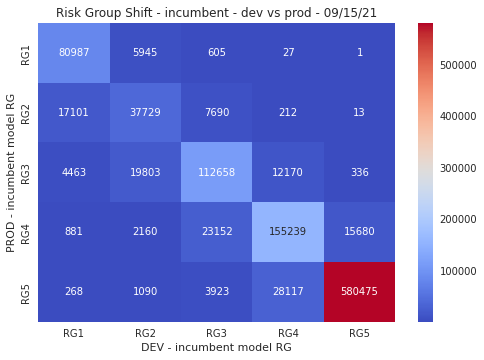

In [36]:
y_col = "PROD - incumbent model RG"
x_col = "DEV - incumbent model RG"
score_df[y_col] = get_risk_groups(score_df["incumbent_model_prod_data"])
score_df[x_col] = get_risk_groups(score_df["incumbent_model_dev_data"])


table = score_df[[y_col, x_col]].value_counts(normalize=False).sort_index().reset_index()
table.columns = [y_col, x_col, 'counts']
table = pd.pivot_table(table, values='counts', index=y_col, 
                       columns=x_col, fill_value=0) 
display(table.sum().sum())
display("lower sum: ", get_lower_sum(table))
display("upper sum: ", get_upper_sum(table))

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.0f')

plt.title(f'Risk Group Shift - incumbent - dev vs prod - 09/15/21')

1110725

'lower sum: '

141814

'upper sum: '

34525

Text(0.5, 1.0, 'Risk Group Shift - refit - dev vs prod - 09/15/21')

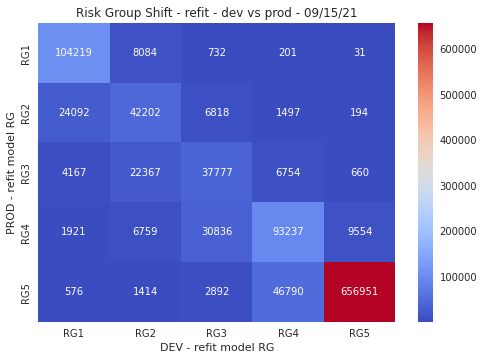

In [37]:
y_col = "PROD - refit model RG"
x_col = "DEV - refit model RG"
score_df[y_col] = get_risk_groups_refitted(score_df["score_prod_data_prod_model"])
score_df[x_col] = get_risk_groups_refitted(score_df["score_dev_data_prod_model"])


table = score_df[[y_col, x_col]].value_counts(normalize=False).sort_index().reset_index()
table.columns = [y_col, x_col, 'counts']
table = pd.pivot_table(table, values='counts', index=y_col, 
                       columns=x_col, fill_value=0) 
display(table.sum().sum())
display("lower sum: ", get_lower_sum(table))
display("upper sum: ", get_upper_sum(table))

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.0f')

plt.title(f'Risk Group Shift - refit - dev vs prod - 09/15/21')

#### Active Population

162368

'lower sum: '

32570

'upper sum: '

7005

Text(0.5, 1.0, 'Risk Group Shift - incumbent - dev vs prod - 09/15/21 - active')

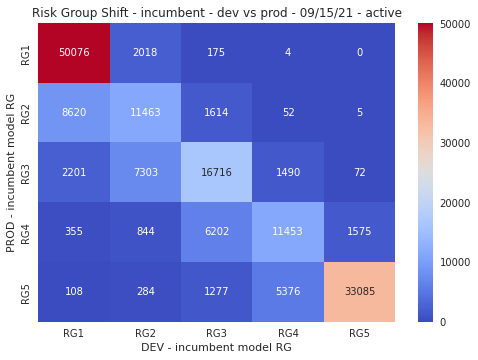

In [38]:
y_col = "PROD - incumbent model RG"
x_col = "DEV - incumbent model RG"
score_df[y_col] = get_risk_groups(score_df["incumbent_model_prod_data"])
score_df[x_col] = get_risk_groups(score_df["incumbent_model_dev_data"])


table = score_df[score_df.is_active][[y_col, x_col]].value_counts(normalize=False).sort_index().reset_index()
table.columns = [y_col, x_col, 'counts']
table = pd.pivot_table(table, values='counts', index=y_col, 
                       columns=x_col, fill_value=0) 
display(table.sum().sum())
display("lower sum: ", get_lower_sum(table))
display("upper sum: ", get_upper_sum(table))

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.0f')

plt.title(f'Risk Group Shift - incumbent - dev vs prod - 09/15/21 - active')

162368

'lower sum: '

37300

'upper sum: '

6669

Text(0.5, 1.0, 'Risk Group Shift - refit - dev vs prod - 09/15/21 - active')

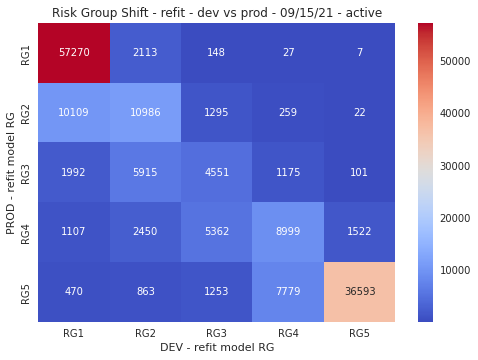

In [39]:
y_col = "PROD - refit model RG"
x_col = "DEV - refit model RG"
score_df[y_col] = get_risk_groups_refitted(score_df["score_prod_data_prod_model"])
score_df[x_col] = get_risk_groups_refitted(score_df["score_dev_data_prod_model"])


table = score_df[score_df.is_active][[y_col, x_col]].value_counts(normalize=False).sort_index().reset_index()
table.columns = [y_col, x_col, 'counts']
table = pd.pivot_table(table, values='counts', index=y_col, 
                       columns=x_col, fill_value=0) 
display(table.sum().sum())
display("lower sum: ", get_lower_sum(table))
display("upper sum: ", get_upper_sum(table))
hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.0f')

plt.title(f'Risk Group Shift - refit - dev vs prod - 09/15/21 - active')


### Risk Group Shifts - hold Data Constant and change model
---

If we swap in the model first before modifying the data pipeline.

```python
score_df["score_dev_data_prod_model"] = score_df["score_prod_exp"]
score_df["score_dev_data_dev_model"] = score_df["score_dev_exp"]
score_df["score_prod_data_prod_model"] = score_df["score_prod_act"]
score_df["score_prod_data_dev_model"] = score_df["score_dev_act"]
score_df["incumbent_model_dev_data"] = score_df["incumbent_model_score_dev_exp"]
score_df["incumbent_model_prod_data"] = score_df["incumbent_model_score_dev_act"]
```

#### Full Population

1110725

'lower sum: '

189359

'upper sum: '

121784

Text(0.5, 1.0, 'Risk Group Shift - PROD - incumbent vs refit - 09/15/21')

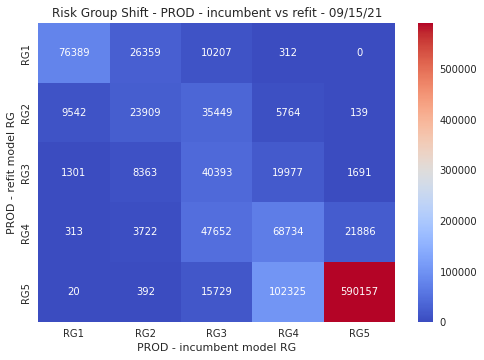

In [42]:
y_col = "PROD - refit model RG"
x_col = "PROD - incumbent model RG"
score_df[y_col] = get_risk_groups_refitted(score_df["score_prod_data_prod_model"])
score_df[x_col] = get_risk_groups(score_df["incumbent_model_prod_data"])


table = score_df[[y_col, x_col]].value_counts(normalize=False).sort_index().reset_index()
table.columns = [y_col, x_col, 'counts']
table = pd.pivot_table(table, values='counts', index=y_col, 
                       columns=x_col, fill_value=0) 
display(table.sum().sum())
display("lower sum: ", get_lower_sum(table))
display("upper sum: ", get_upper_sum(table))

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.0f')

plt.title(f'Risk Group Shift - PROD - incumbent vs refit - 09/15/21')

1110725

'lower sum: '

173696

'upper sum: '

148165

Text(0.5, 1.0, 'Risk Group Shift - DEV - incumbent vs refit - 09/15/21')

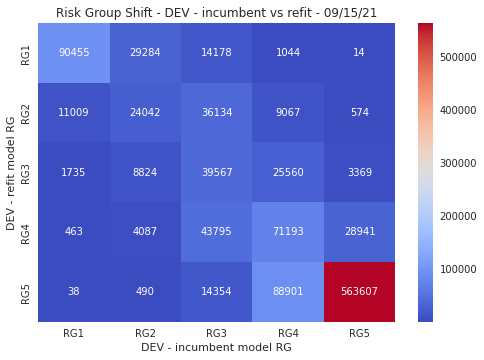

In [43]:
y_col = "DEV - refit model RG"
x_col = "DEV - incumbent model RG"
score_df[y_col] = get_risk_groups_refitted(score_df["score_dev_data_prod_model"])
score_df[x_col] = get_risk_groups(score_df["incumbent_model_dev_data"])


table = score_df[[y_col, x_col]].value_counts(normalize=False).sort_index().reset_index()
table.columns = [y_col, x_col, 'counts']
table = pd.pivot_table(table, values='counts', index=y_col, 
                       columns=x_col, fill_value=0) 
display(table.sum().sum())
display("lower sum: ", get_lower_sum(table))
display("upper sum: ", get_upper_sum(table))

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.0f')

plt.title(f'Risk Group Shift - DEV - incumbent vs refit - 09/15/21')

#### Active Population

162368

'lower sum: '

26136

'upper sum: '

29020

Text(0.5, 1.0, 'Risk Group Shift - PROD - incumbent vs refit - 09/15/21 - active')

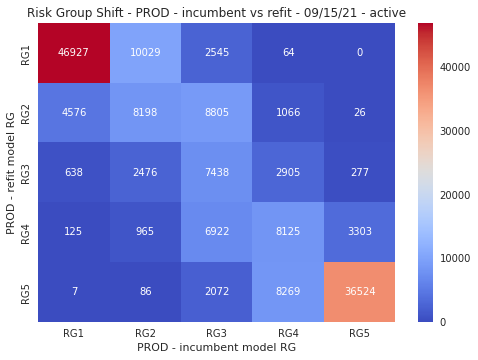

In [44]:
y_col = "PROD - refit model RG"
x_col = "PROD - incumbent model RG"
score_df[y_col] = get_risk_groups_refitted(score_df["score_prod_data_prod_model"])
score_df[x_col] = get_risk_groups(score_df["incumbent_model_prod_data"])


table = score_df[score_df.is_active][[y_col, x_col]].value_counts(normalize=False).sort_index().reset_index()
table.columns = [y_col, x_col, 'counts']
table = pd.pivot_table(table, values='counts', index=y_col, 
                       columns=x_col, fill_value=0) 
display(table.sum().sum())
display("lower sum: ", get_lower_sum(table))
display("upper sum: ", get_upper_sum(table))

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.0f')

plt.title(f'Risk Group Shift - PROD - incumbent vs refit - 09/15/21 - active')

162368

'lower sum: '

22268

'upper sum: '

32843

Text(0.5, 1.0, 'Risk Group Shift - DEV - incumbent vs refit - 09/15/21 - active')

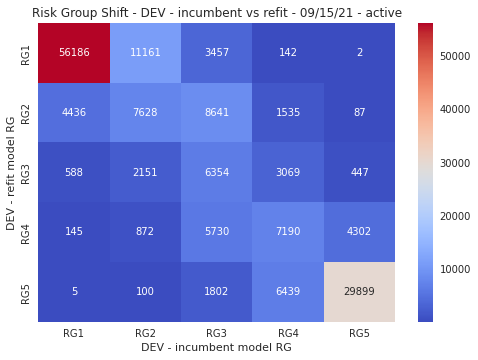

In [45]:
y_col = "DEV - refit model RG"
x_col = "DEV - incumbent model RG"
score_df[y_col] = get_risk_groups_refitted(score_df["score_dev_data_prod_model"])
score_df[x_col] = get_risk_groups(score_df["incumbent_model_dev_data"])


table = score_df[score_df.is_active][[y_col, x_col]].value_counts(normalize=False).sort_index().reset_index()
table.columns = [y_col, x_col, 'counts']
table = pd.pivot_table(table, values='counts', index=y_col, 
                       columns=x_col, fill_value=0) 
display(table.sum().sum())
display("lower sum: ", get_lower_sum(table))
display("upper sum: ", get_upper_sum(table))

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.0f')

plt.title(f'Risk Group Shift - DEV - incumbent vs refit - 09/15/21 - active')

### Behavior By Risk Groups, Segmented by respective logics
---

In [38]:
score_df.head()

,user_id,business_account_number_exp,score_prod_exp,score_prod_act,score_dev_exp,score_dev_act,incumbent_model_score_dev_exp,incumbent_model_score_dev_act,score_dev_data_prod_model,score_dev_data_dev_model,...,sample_date,is_active,PROD - incumbent model risk group,DEV - incumbent model risk group,PROD - refit model RG,DEV - refit model RG,PROD - refit model risk group,DEV - refit model risk group,PROD - incumbent model RG,DEV - incumbent model RG
0,305,410000276182,613.927501,616.901309,613.927501,616.901309,574.411334,573.720213,613.927501,613.927501,...,2021-09-15,False,RG4,RG4,RG5,RG5,RG5,RG5,RG4,RG4
1,361,410000345005,476.012318,483.753944,476.012318,483.753944,478.306634,496.458316,476.012318,476.012318,...,2021-09-15,True,RG2,RG2,RG1,RG1,RG1,RG1,RG2,RG2
2,637,410000300440,471.937248,445.956154,471.937248,445.956154,450.108314,444.716727,471.937248,471.937248,...,2021-09-15,True,RG1,RG1,RG1,RG1,RG1,RG1,RG1,RG1
3,457,410011645378,543.099431,550.634507,543.099431,550.634507,503.178169,500.620276,543.099431,543.099431,...,2021-09-15,False,RG2,RG2,RG3,RG2,RG3,RG2,RG2,RG2
4,468,410000331898,559.857236,559.977979,559.857236,559.977979,550.282359,525.433384,559.857236,559.857236,...,2021-09-15,False,RG3,RG3,RG3,RG3,RG3,RG3,RG3,RG3


#### columns:
```python
"PROD - incumbent model RG"
"DEV - incumbent model RG"
"PROD - refit model RG"
"DEV - refit model RG"
```

#### 

#### Full Population

```python
score_df["score_dev_data_prod_model"] = score_df["score_prod_exp"]
score_df["score_dev_data_dev_model"] = score_df["score_dev_exp"]
score_df["score_prod_data_prod_model"] = score_df["score_prod_act"]
score_df["score_prod_data_dev_model"] = score_df["score_dev_act"]
score_df["incumbent_model_dev_data"] = score_df["incumbent_model_score_dev_exp"]
score_df["incumbent_model_prod_data"] = score_df["incumbent_model_score_dev_act"]
```

In [52]:
target_col = "target_1229"

In [63]:
# refit model on prod data

score_col = "score_prod_data_prod_model"
rg_mapper = get_risk_groups_refitted
score_df["rg_tmp"] = rg_mapper(score_df[score_col])
display(score_df.groupby("rg_tmp")[target_col].agg(["mean", "sum", "count"]))

,mean,sum,count
rg_tmp,,,
RG1,0.001104,125,113267
RG2,0.003355,251,74803
RG3,0.004085,293,71725
RG4,0.005312,756,142307
RG5,0.009775,6927,708623


In [66]:
# incumbent model on prod data

score_col = "incumbent_model_prod_data"
rg_mapper = get_risk_groups
score_df["rg_tmp"] = rg_mapper(score_df[score_col])
display(score_df.groupby("rg_tmp")[target_col].agg(["mean", "sum", "count"]))

,mean,sum,count
rg_tmp,,,
RG1,0.001485,130,87565
RG2,0.003554,223,62745
RG3,0.005467,817,149430
RG4,0.006732,1327,197112
RG5,0.009538,5855,613873


In [65]:
# refit model on dev data

score_col = "score_dev_data_prod_model"
rg_mapper = get_risk_groups_refitted
score_df["rg_tmp"] = rg_mapper(score_df[score_col])
display(score_df.groupby("rg_tmp")[target_col].agg(["mean", "sum", "count"]))

,mean,sum,count
rg_tmp,,,
RG1,0.002126,287,134975
RG2,0.004961,401,80826
RG3,0.005136,406,79055
RG4,0.006344,942,148479
RG5,0.009464,6316,667390


#### Active Population

```python
score_df["score_dev_data_prod_model"] = score_df["score_prod_exp"]
score_df["score_dev_data_dev_model"] = score_df["score_dev_exp"]
score_df["score_prod_data_prod_model"] = score_df["score_prod_act"]
score_df["score_prod_data_dev_model"] = score_df["score_dev_act"]
score_df["incumbent_model_dev_data"] = score_df["incumbent_model_score_dev_exp"]
score_df["incumbent_model_prod_data"] = score_df["incumbent_model_score_dev_act"]
```

In [68]:
# refit model on prod data

score_col = "score_prod_data_prod_model"
rg_mapper = get_risk_groups_refitted
score_df_active["rg_tmp"] = rg_mapper(score_df_active[score_col])
display(score_df_active.groupby("rg_tmp")[target_col].agg(["mean", "sum", "count"]))

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,sum,count
rg_tmp,,,
RG1,0.001545,92,59565
RG2,0.008513,193,22671
RG3,0.014490,199,13734
RG4,0.027109,527,19440
RG5,0.086375,4056,46958


In [69]:
# incumbent model on prod data

score_col = "incumbent_model_prod_data"
rg_mapper = get_risk_groups
score_df_active["rg_tmp"] = rg_mapper(score_df_active[score_col])
display(score_df_active.groupby("rg_tmp")[target_col].agg(["mean", "sum", "count"]))

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,sum,count
rg_tmp,,,
RG1,0.002009,105,52273
RG2,0.008090,176,21754
RG3,0.021345,593,27782
RG4,0.041852,855,20429
RG5,0.083180,3338,40130


In [70]:
# refit model on dev data

score_col = "score_dev_data_prod_model"
rg_mapper = get_risk_groups_refitted
score_df_active["rg_tmp"] = rg_mapper(score_df_active[score_col])
display(score_df_active.groupby("rg_tmp")[target_col].agg(["mean", "sum", "count"]))

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,sum,count
rg_tmp,,,
RG1,0.003312,235,70948
RG2,0.013526,302,22327
RG3,0.023951,302,12609
RG4,0.036022,657,18239
RG5,0.093372,3571,38245


#### Explore the the time when Kafka started to perform correctly
---

One way to explore whether the Kafka topic will perform correctly is to explore the differences between user features across their onboarding time.

This is not a perfect measure, but a okay proxy given our time. We will need to look into short team features such as:

* after account being openned
    * transaction_as_pct_of_balance
    * sum_deposits_10d
    * bal_ratio
    * dollar_val_returns_3d
* during account openning
    * lag_acc_open_first_transaction


* Recipe:
    * get account open date
    * compare values between prod and dev, how about when one is missing but not the other one?
    * group by month/quarter, and compute difference (normalize by counts)

In [11]:
incumbent_model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_target_no_giact_time_since_last_link.pkl"
refitted_model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_refit_20201231_wo_ind.pkl"

with open(incumbent_model_path, "rb") as f:
    incumbent_model = pkl.load(f)
    
with open(refitted_model_path, "rb") as f:
    refitted_model = pkl.load(f)

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [12]:
combined_df.shape

(1110725, 163)

In [13]:
trnx_cols = ['transaction_as_pct_of_balance',
             'sum_deposits_10d',
             'bal_ratio',
             'dollar_val_returns_3d',
             'lag_acc_open_first_transaction',
             'credit_card_loan_amount']
dev_cols = [c + "_exp" for c in trnx_cols]
prod_cols = [c + "_act" for c in trnx_cols]

In [20]:
# load banking accounts to get account open date
ba_df = pd.read_feather("../../data/processed/processed_1640826096/banking_accounts_1640826096.feather")
combined_df_w_dt = combined_df.merge(ba_df[["business_account_number", "user_id", "date_account_opened"]],
                                     on=["business_account_number", "user_id"], how="left")

# make sure the merge did not produce duplicated records
combined_df_w_dt.shape, combined_df.shape, combined_df_w_dt.date_account_opened.isna().any()

((1110725, 164), (1110725, 163), False)

In [21]:
active = False
if active:
    combined_df_w_dt = combined_df_w_dt[combined_df_w_dt.is_active]

In [22]:
combined_df_w_dt.shape

(1110725, 164)

<AxesSubplot:>

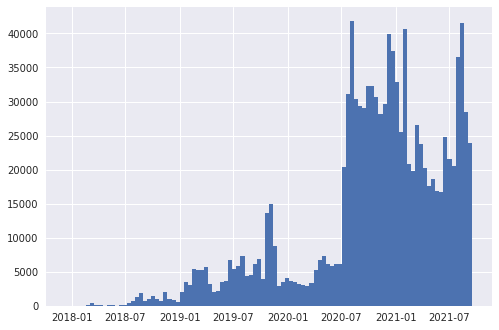

In [23]:
combined_df_w_dt["date_account_opened"].hist(bins=100)

In [24]:
def rmse(s):
    return (s ** 2).mean() ** 0.5

#### by quarter

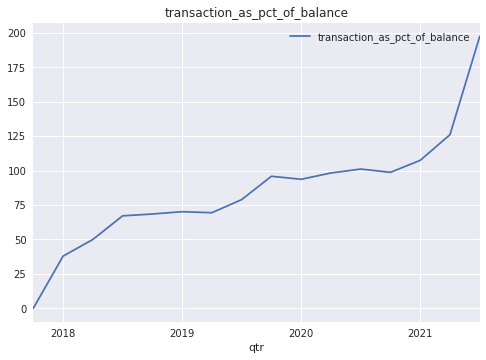

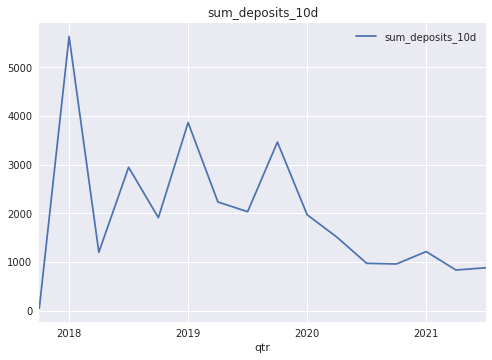

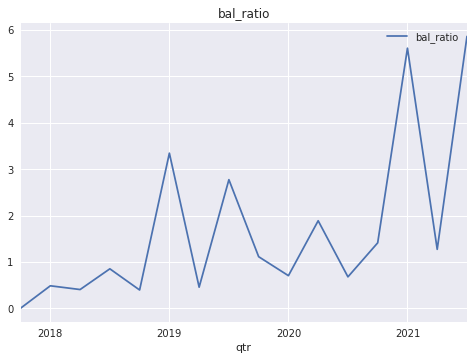

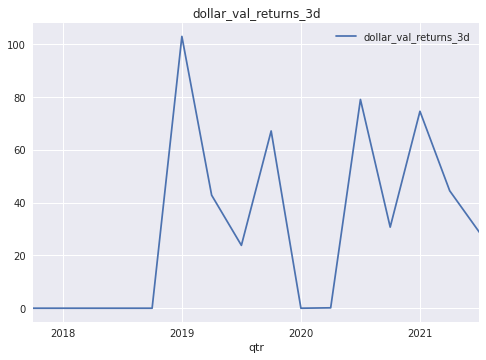

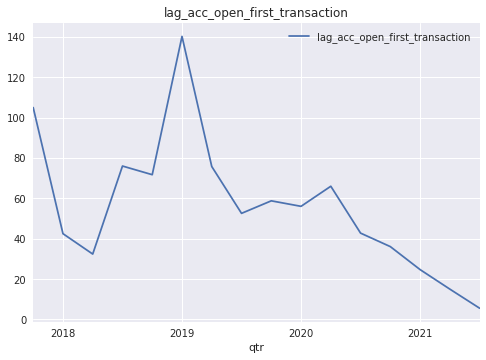

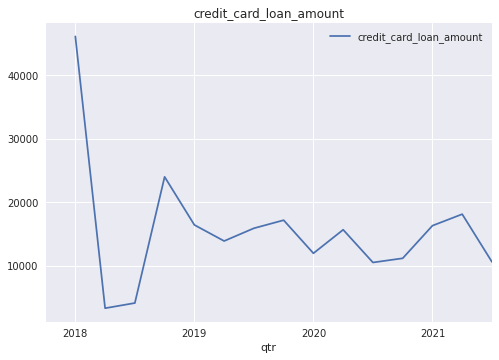

In [18]:
combined_df_w_dt["qtr_account_opened"] = pd.PeriodIndex(data=combined_df_w_dt["date_account_opened"], freq="Q")

for c in trnx_cols:

    dev_col = c + "_exp"
    prod_col = c + "_act"
    diff = combined_df_w_dt[dev_col] - combined_df_w_dt[prod_col]
    diff = diff.rename("diff").to_frame()
    diff["qtr"] = combined_df_w_dt["qtr_account_opened"]

    diff.groupby("qtr")["diff"].apply(rmse).plot(label=c)
    plt.legend()
    plt.title(c)
    plt.show()


#### by month

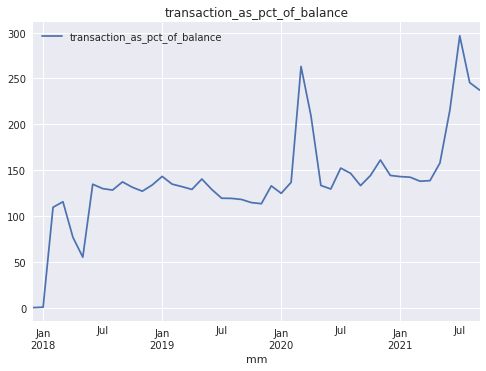

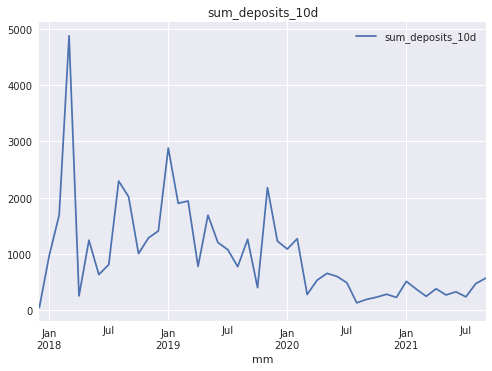

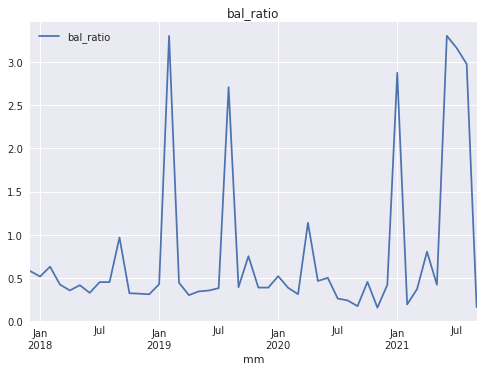

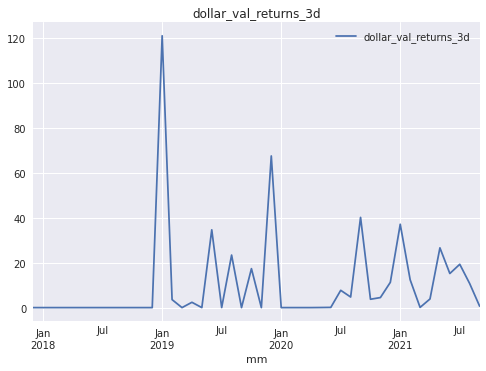

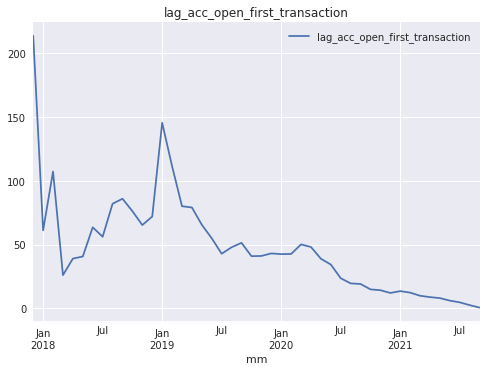

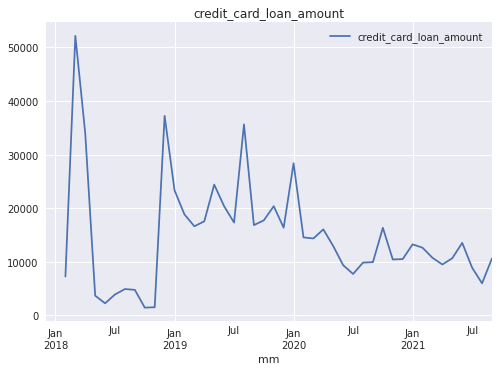

In [27]:
combined_df_w_dt["mm_account_opened"] = pd.PeriodIndex(data=combined_df_w_dt["date_account_opened"], freq="M")

for c in trnx_cols:

    dev_col = c + "_exp"
    prod_col = c + "_act"
    diff = combined_df_w_dt[dev_col] - combined_df_w_dt[prod_col]
    diff = diff.rename("diff").to_frame()
    diff["mm"] = combined_df_w_dt["mm_account_opened"]

    diff.groupby("mm")["diff"].apply(rmse).plot(label=c)
    plt.legend()
    plt.title(c)
    plt.show()

In [ ]:
# count of missing kafka topics between prod and dev on given days
# 